### Testing cloud-cover detection with a clear-sky LWd ensemble @ CUES

Estimate the clear-sky downward longwave using several different methods. Test these functions, and then compare the ensemble mean clear-sky downward longwave (LWd) to measured LWd at the CUES site to try and identify cloud-cover. We expect observed LWd to be greater than estimated clear-sky LWd when we have cloud-cover. This should be especially useful for identifying cloud-cover during nighttime when we don't have shortwave solar radiation to also check if we have sunny or cloudy skies. We can take a look at the GOES-16 ABI IR observations from the same time, where we expect to see cold cloud-tops when they pass over the site.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

Import the clear-sky downward longwave functions:

In [2]:
import lw_clr

Define functions we'll use

In [3]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
---
# Test the LW functions:

Load observations from CUES site:

In [4]:
cues_ds = pd.read_pickle('CUES_L1_Temp_Rad_2017-2019.pkl').to_xarray()

Load GOES observations for the CUES site

In [6]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


#### Run ensemble of all these LW estimation methods:

Set up input variables from CUES observations:

In [14]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
Ta = T + 273.15 # temperature [K]
#Ta = Ta.where((Ta>250)&(Ta<300)) # I noticed some erroneous looking temperature values in Sept. 2018, try filtering those out here
Qsi = cues_ds['upward looking solar radiation; uplooking Eppley Lab precision spectral pyranometer; (Watts/meter^2)']
elev = 2940 # meters

In [61]:
import cloud_detect

In [63]:
LWd_obs = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
sun_flag_obs = cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']

In [ ]:
LWd_pred, confusion_matrix = cloud_detect.lw_cloud_detect(Ta, RH, LWd_obs, sun_flag_obs, elev, threshold=0)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Run the ensemble function

In [16]:
lw_ensemble = lw_clr.ensemble(Ta, RH, elev)

Add all the results to the CUES dataset:

In [17]:
cues_ds = xr.merge([cues_ds, lw_ensemble])

Create a "day_flag" for hours throughout the year (so including shorter winter days) when we exect to see sunlight if there are no clouds. (I've chosen here to designate 8am-4pm as "day")

In [18]:
daystarthour = 8
dayendhour = 16
day_flag =  [1 if (pd.Timestamp(x).hour > daystarthour) & (pd.Timestamp(x).hour < dayendhour) else 0 for x in cues_ds['datetime'].values]
cues_ds['day_flag'] = (['datetime'],  day_flag)

In [19]:
cues_ds

<xarray.Dataset>
Dimensions:                                                                                                                  (datetime: 1466937)
Coordinates:
  * datetime                                                                                                                 (datetime) datetime64[ns] 2017-03-01 ... 2019-12-30T23:59:00
Data variables:
    Platform relative humidity; platform temperature/relative humidity; (percent)                                            (datetime) float64 51.3 ... 91.5
    Platform temperature; platform temperature/relative humidity; (degrees Celsius)                                          (datetime) float64 -4.8 ... -7.2
    snow temperature 1; thermister 1; (degrees Celsius)                                                                      (datetime) float64 -0.1 ... nan
    snow temperature 2; thermister 2; (degrees Celsius)                                                                      (datetime) float64 -1.8 ... nan
    snow temperature 3; thermister 3; (degrees Celsius)                                                                      (datetime) float64 -51.9 ... nan
    snow temperature 4; thermister 4; (degrees Celsius)                                                                      (datetime) float64 -5.9 ... nan
    snow temperature 5; thermister 5; (degrees Celsius)                                                                      (datetime) float64 -6.0 ... nan
    snow temperature 6; thermister 6; (degrees Celsius)                                                                      (datetime) float64 -7.5 ... nan
    snow temperature 7; thermister 7; (degrees Celsius)                                                                      (datetime) float64 -23.2 ... nan
    snow temperature 8; thermister 8; (degrees Celsius)                                                                      (datetime) float64 -26.0 ... nan
    soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)                                                      (datetime) float64 0.3 ... 0.1
    soil temperature @ 10cm; soil temp at 10cm  center; (degrees Celsius)                                                    (datetime) float64 0.3 ... -1.2
    soil temperature @ 20cm; soil temp at 20cm  center; (degrees Celsius)                                                    (datetime) float64 0.6 ... 0.5
    soil temperature @ 30cm; soil temp at 30cm  center; (degrees Celsius)                                                    (datetime) float64 -0.7 ... -1.5
    soil temperature @ 40cm; soil temp at 40cm  center; (degrees Celsius)                                                    (datetime) float64 0.4 ... 0.3
    soil temperature @ 50cm; soil temp at 50cm  center; (degrees Celsius)                                                    (datetime) float64 0.9 ... 1.1
    soil temperature @ 60cm; soil temp at 60cm  center; (degrees Celsius)                                                    (datetime) float64 0.8 ... 0.2
    soil temperature @ 70cm; soil temp at 70cm  center; (degrees Celsius)                                                    (datetime) float64 1.1 ... 1.5
    soil temperature @ 80cm; soil temp at 80cm  center; (degrees Celsius)                                                    (datetime) float64 1.7 ... 1.6
    soil temperature @ 90cm; soil temp at 90cm  center; (degrees Celsius)                                                    (datetime) float64 2.0 ... 2.2
    CO2 concentration; bunker air temperature  atmospheric pressure and CO2 sensor; (parts per million)                      (datetime) float64 5.008e+03 ... 991.0
    bunker temperature; bunker air temperature  atmospheric pressure and CO2 sensor; (degrees Celsius)                       (datetime) float64 13.3 ... 11.3
    bunker air pressure  not adjusted; bunker air temperature  atmospheric pressure and CO2 sensor; (millibars)              (datetime) float64 714.0 ... 713.0
   

---
---
# Plot results:

Set up font sizes for plot

In [20]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For each estimation method, plot the estimated clear-sky LWd versus observed all-sky LWd:

In [21]:
# Function for making these plots
def plot_2dhist_LWensemble(x,y_,row,col):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax[row,col].imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax[row,col].plot([0,400],[0,400],'-',c='grey')
    ax[row,col].text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax[row,col].text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax[row,col].set_xlim([100,400])
    ax[row,col].set_ylim([100,400])
    ax[row,col].set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax[row,col].set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax[row,col].set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

def plot_2dhist_LW(x,y_):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax.plot([0,400],[0,400],'-',c='grey')
    ax.text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax.text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax.set_xlim([100,400])
    ax.set_ylim([100,400])
    ax.set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax.set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax.set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

In [22]:
x = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = [cues_ds.lclr_angstrom1918,cues_ds.lclr_brunt1932,cues_ds.lclr_brutsaert1975,cues_ds.lclr_garratt1992,
     cues_ds.lclr_idsojackson1969, cues_ds.lclr_idso1981,cues_ds.lclr_iziomon2003,cues_ds.lclr_keding1989,
     cues_ds.lclr_niemela2001,cues_ds.lclr_prata1996,cues_ds.lclr_satturlund1979,cues_ds.lclr_swinbank1963,
     cues_ds.lclr_dilleyobrien1998,cues_ds.lclr_maykutchurch1973,
     cues_ds.lclr_campbellnorman1998,cues_ds.lclr_ohmura1982,cues_ds.lclr_efimova1961,
     cues_ds.lclr_mean, cues_ds.lclr_min, cues_ds.lclr_max]

Plot the estimated clear-sky downward longwave against observed downward longwave for each method (as well as our mean, min, max of all methods).

We expect these clear-sky methods to roughly match with observations when we actually do have clear-sky conditions.

When we have clouds, we should see the clear-sky methods underestimating the downward longwave flux.

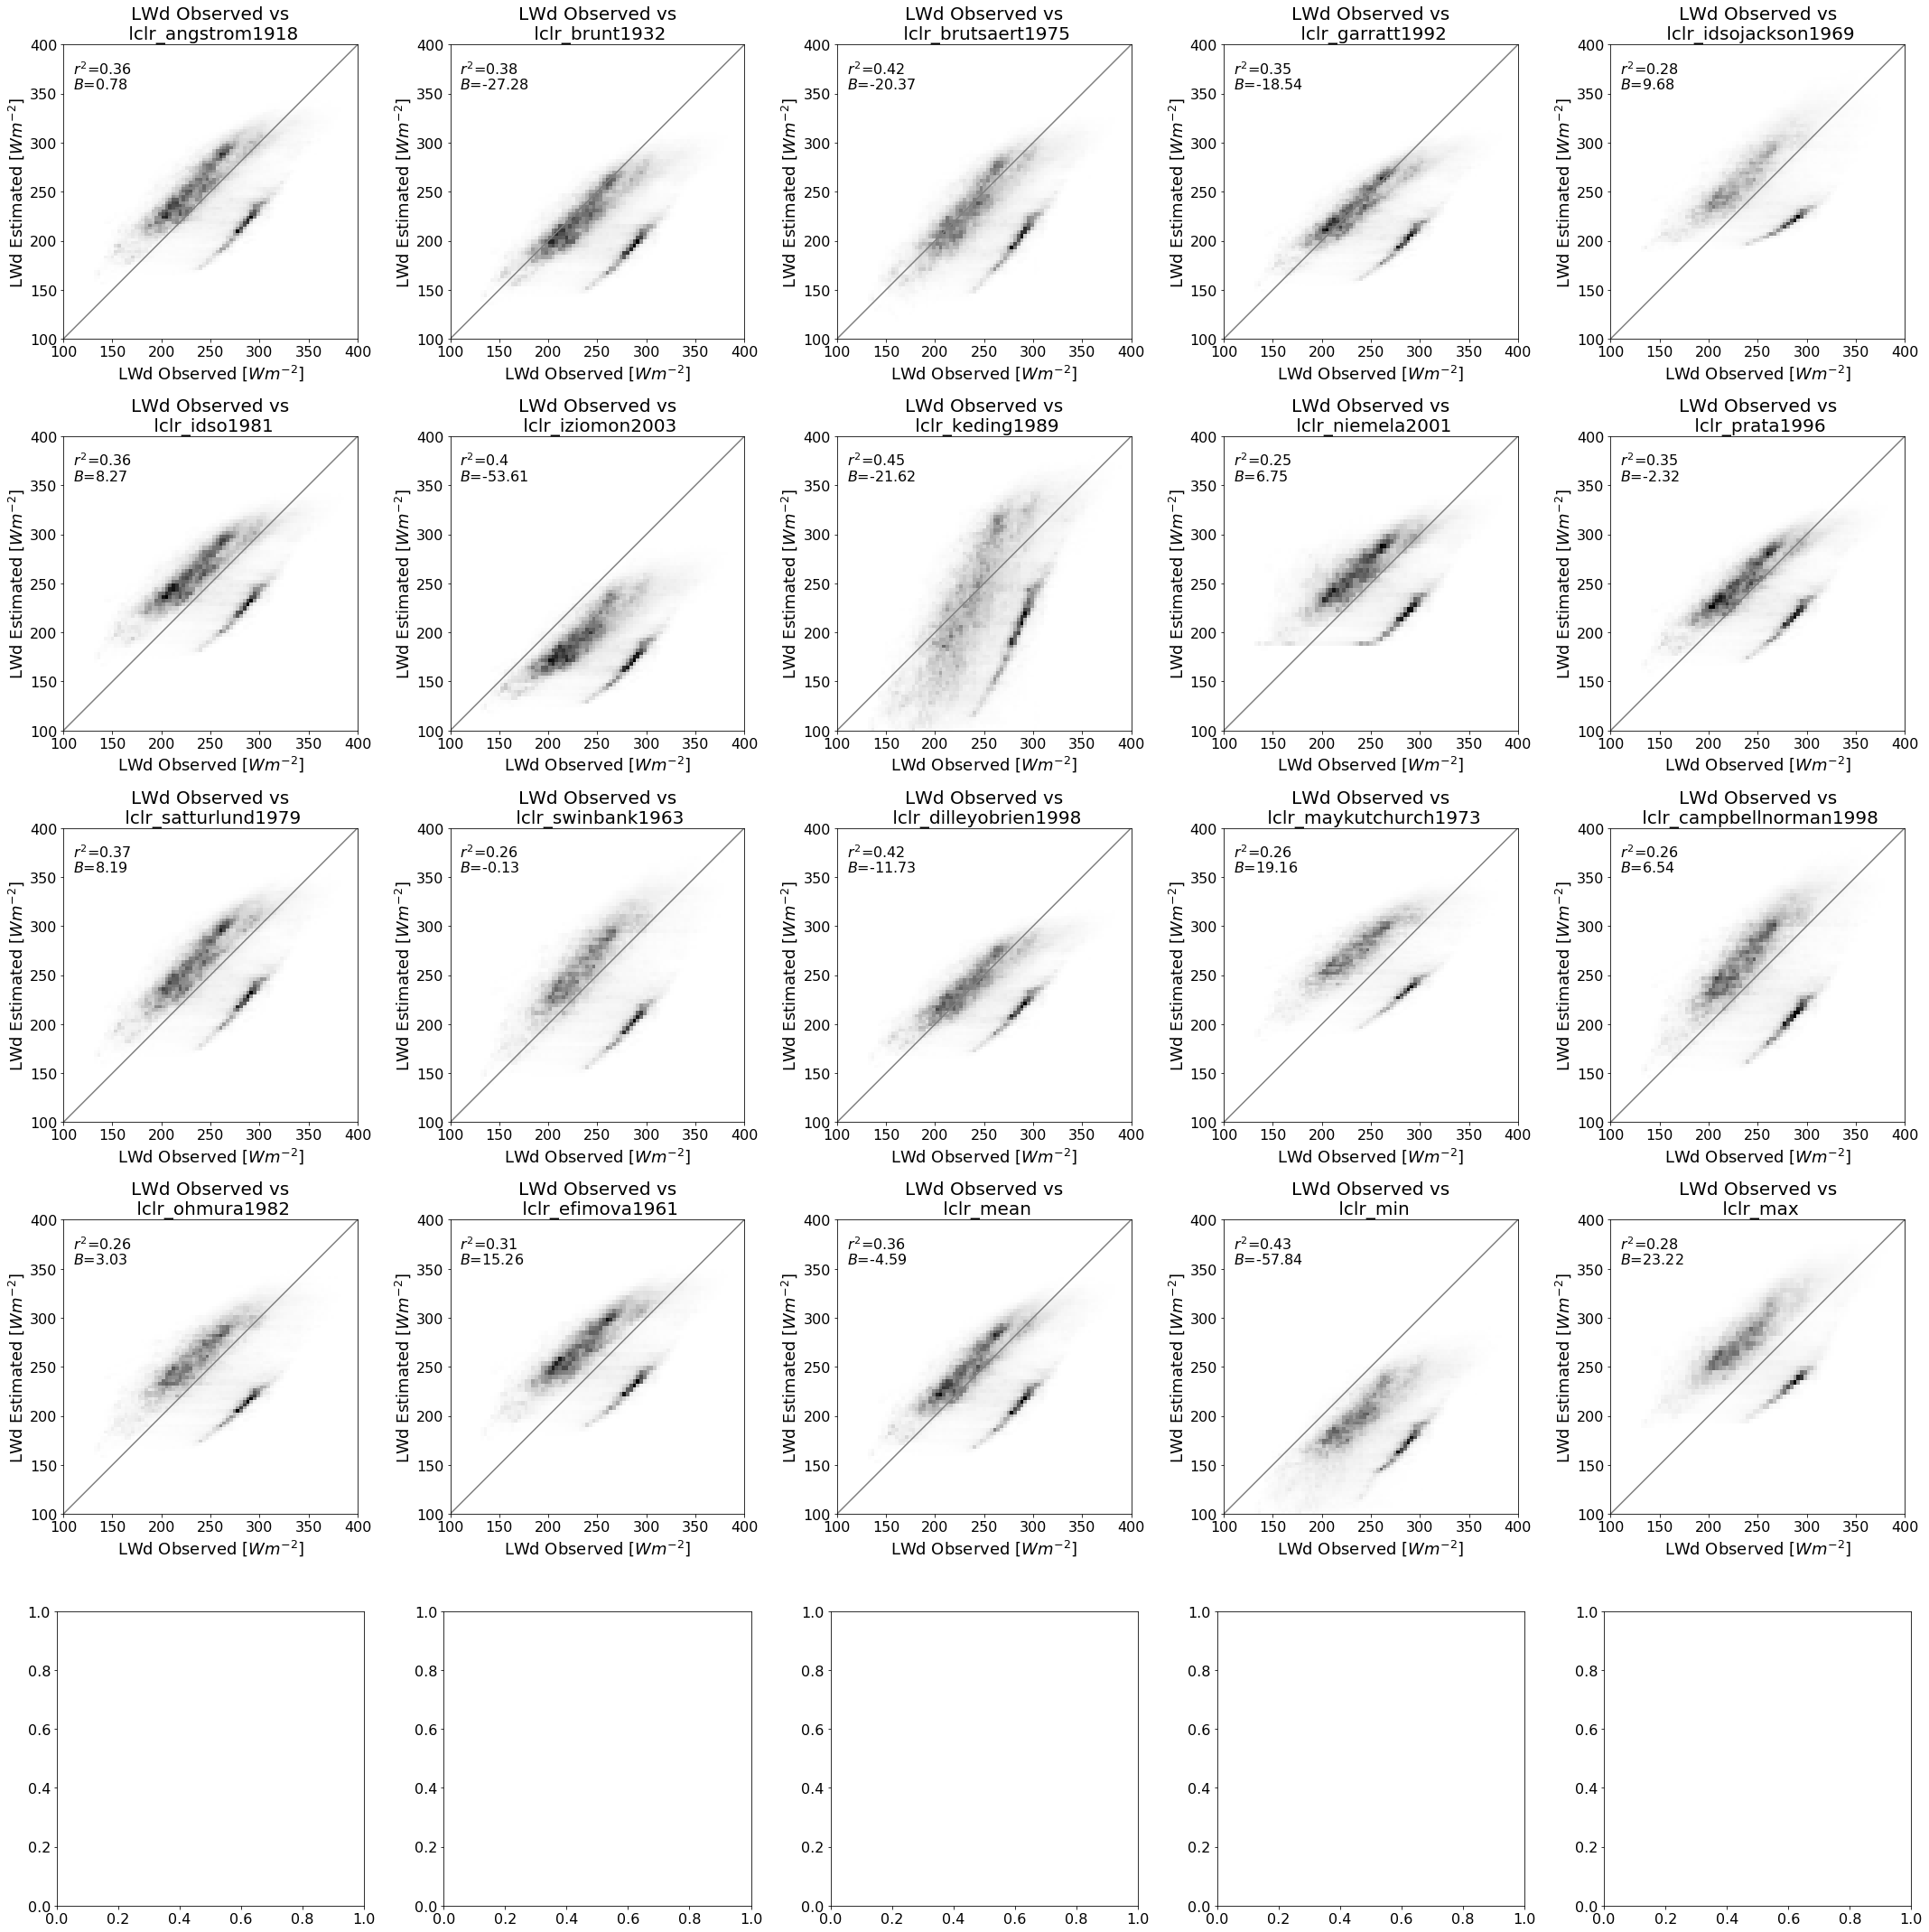

In [23]:
r, c = 4, 5
fig, ax = plt.subplots(c,r,figsize=(30,30))
for row in range(0,r):
    for col in range(0,c):
        try:
            plot_2dhist_LWensemble(x,y[(row*5)+col],row,col)
        except IndexError:
            pass
plt.tight_layout()

Now plot only for our known clear-sky conditions (sun flag = 1).

This corresponds to only daytime clear skies when the pyranometer saw the sun (therefore we aren't seeing night time clear skies).

We can later use this sun flag as validation data to check our cloud detection method (and compute a confusion matrix).

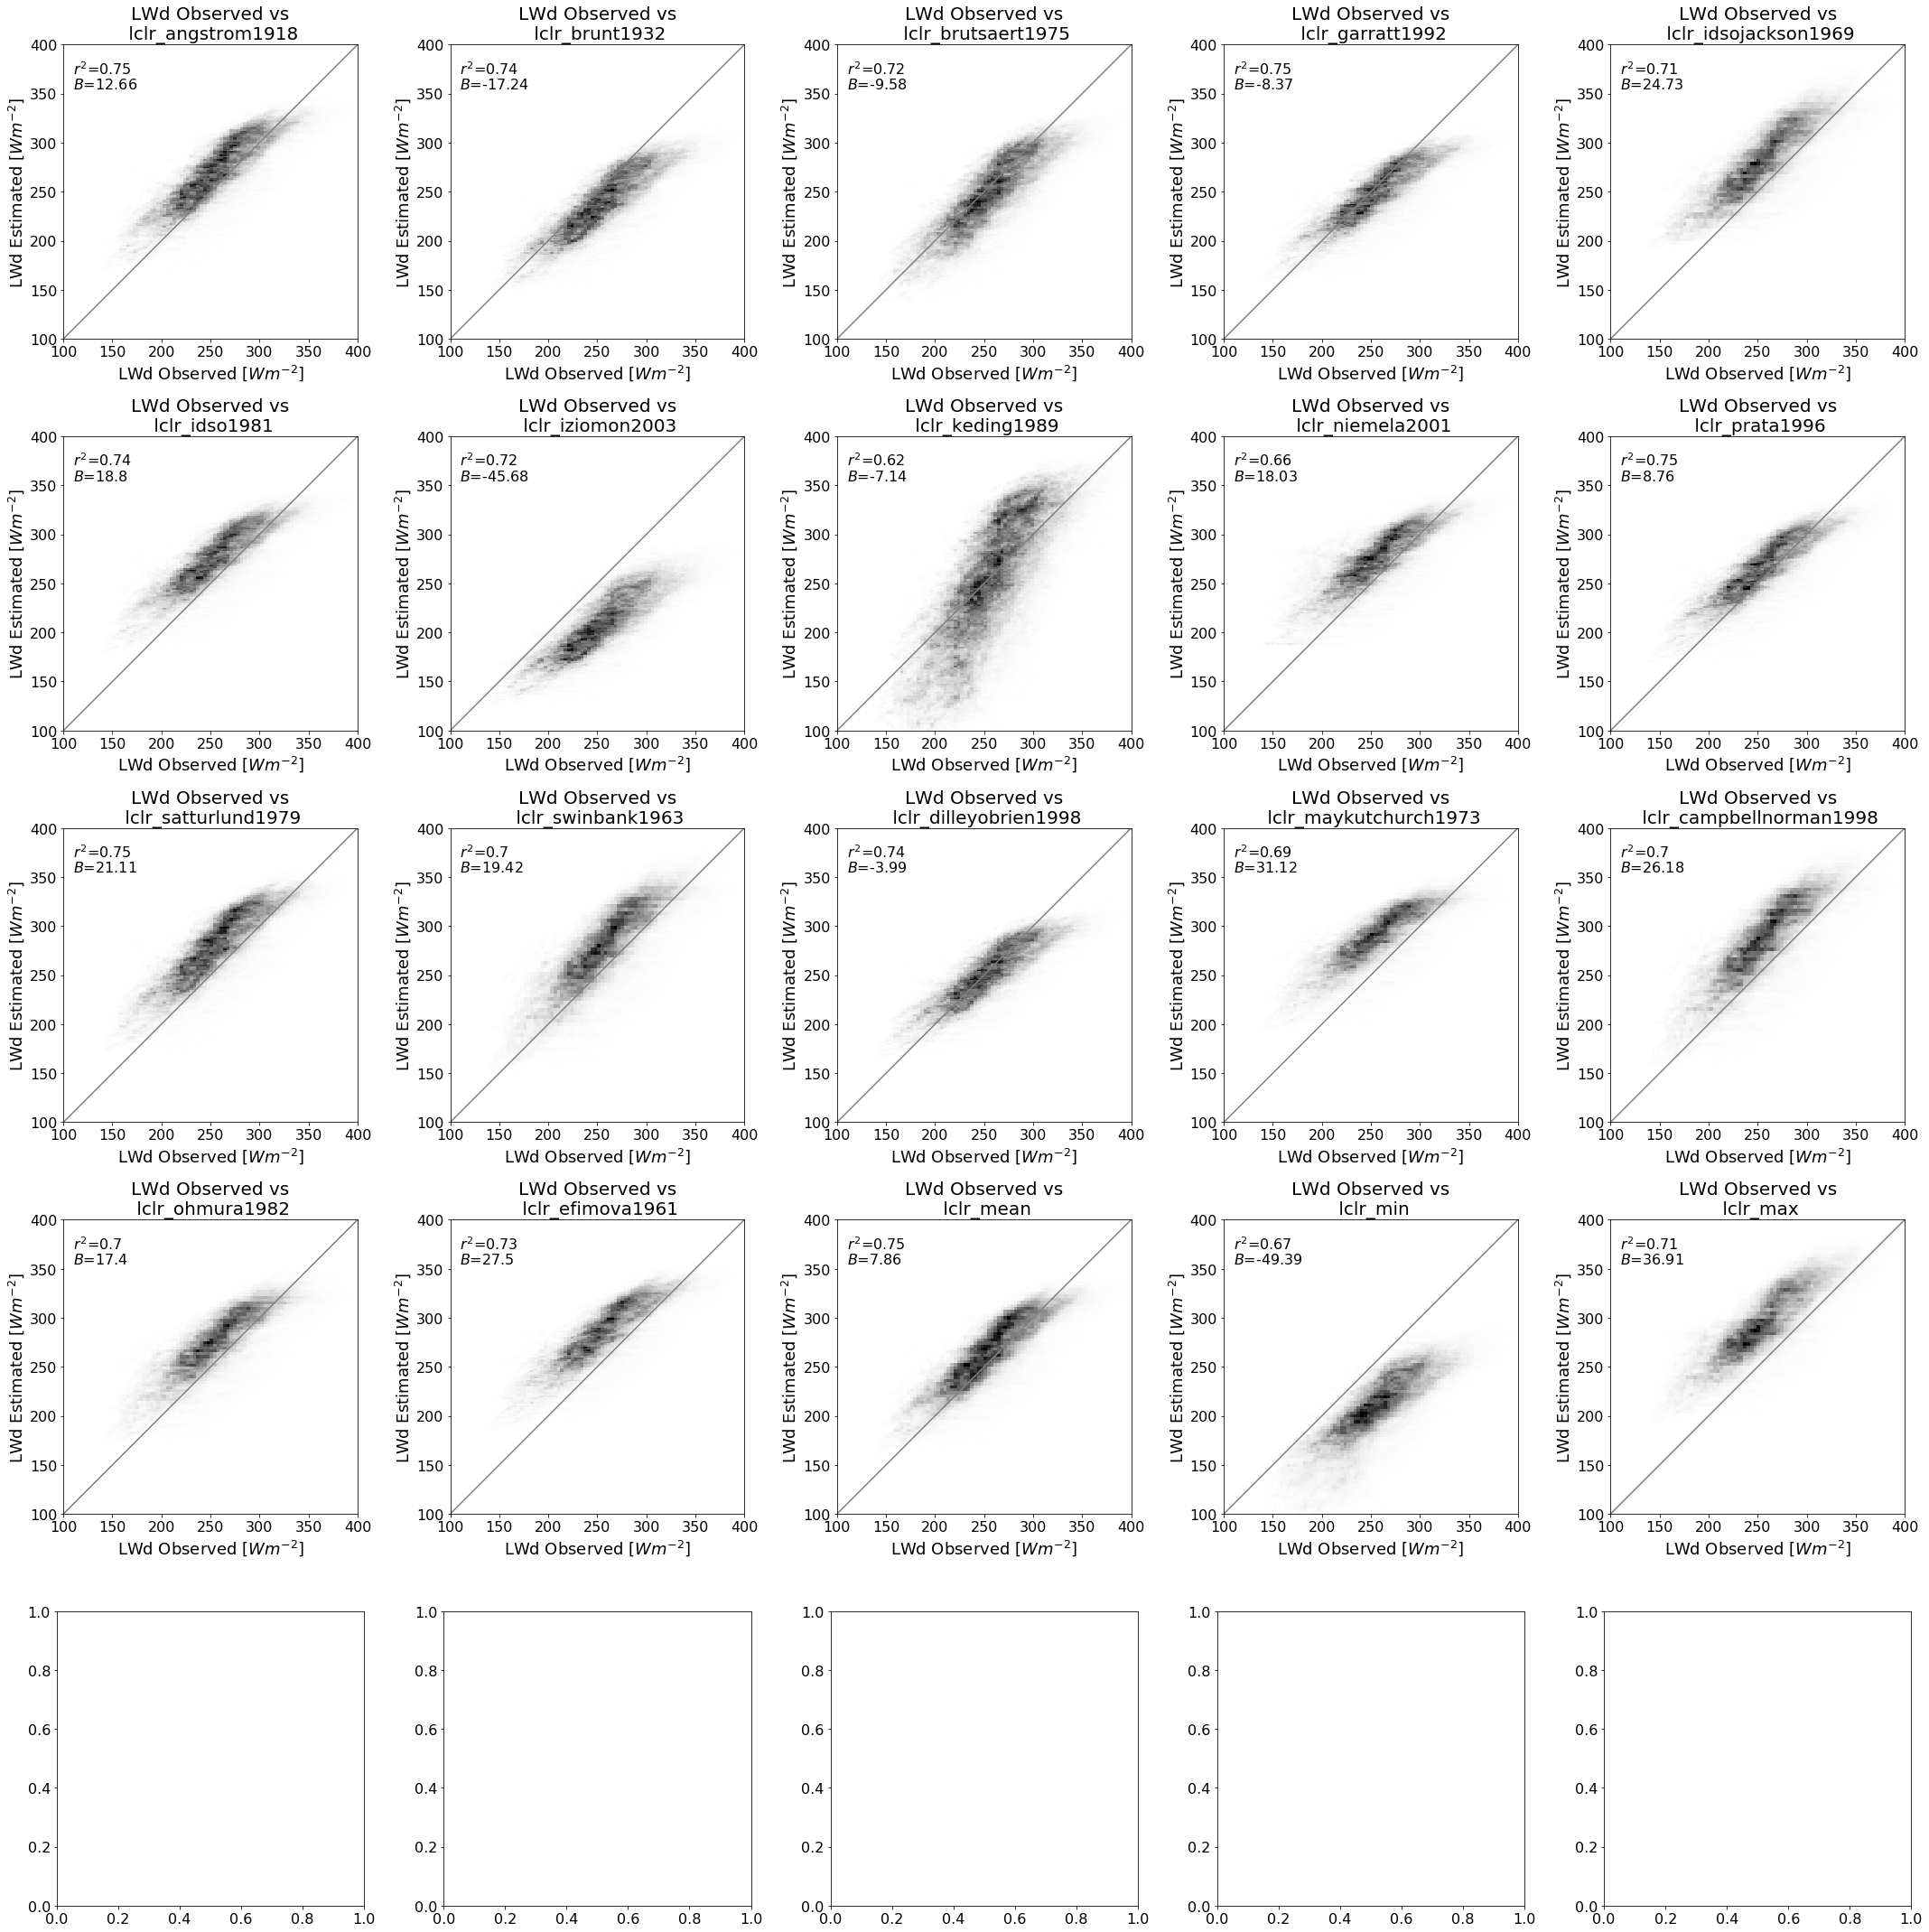

In [25]:
r, c = 4, 5
fig, ax = plt.subplots(c,r,figsize=(30,30))
for row in range(0,r):
    for col in range(0,c):
        try:
            plot_2dhist_LWensemble(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                                   y[(row*5)+col].where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
                                   ,row,col)
        except IndexError:
            pass
plt.tight_layout()

Plotting the ensemble mean against observed LWd for all data points, and then for only our known clear sky conditions (where sun flag = 1).

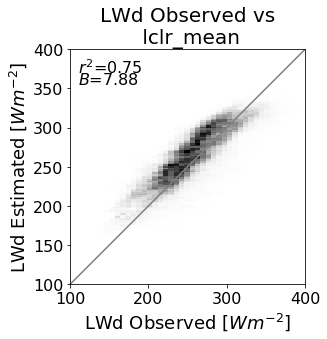

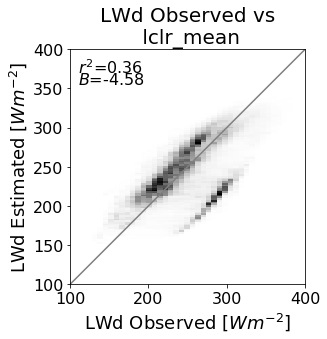

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
plot_2dhist_LW(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                cues_ds.lclr_mean.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1))

plt.tight_layout()


fig, ax = plt.subplots(figsize=(5,5))

plot_2dhist_LW(x,cues_ds.lclr_mean)

plt.tight_layout()



***
***
#### Cloud Detect

Make a cloud flag where we think there's cloud cover

We can set a threshold of allowance above the ensemble mean estimated LWd value where we say there are still no clouds.

(I'm not sure what this value should be, so we can do some tests to find a good value later)

In [29]:
threshold = 25 # threshold above ensemble mean [W^m-2]

In [30]:
cloud_flag = np.zeros_like(cues_ds.lclr_mean.values) # create array of zeros (cloud_flag = 0, no clouds)

In [31]:
# Conditional statement to determine if we think we have clouds:
# if LWd_observed > LWd_clearsky + threshold
lw_cloud_condition = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'] > cues_ds.lclr_mean + threshold

# Set our cloud_flag = 1 whenever this condition is true
cloud_flag[lw_cloud_condition] = 1

# Add the cloud flag to the dataset
cues_ds['cloud_flag'] = (['datetime'],  cloud_flag)

#### Compute a confusion matrix

In [ ]:
# Predictions: get the cloud flag values where we know we're in daytime hours
y_pred = cues_ds.cloud_flag.where(cues_ds.day_flag == 1)
# (note that I am inverting the value of the cloud flag so it is now a "sun flag")
y_pred = np.abs( y_pred - 1 )

# Actual: get the sun flag values where we know we're in daytime hours
y_actual = cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'].where(cues_ds.day_flag == 1)

# Set up a dataframe with these the sun and cloud flags for daytime hours
data = {
        'sun_actual':    y_actual,
        'sun_predicted': y_pred 
        }
df = pd.DataFrame(data, columns=['sun_actual','sun_predicted'])

# Compute the confusion matrix:
confusion_matrix = pd.crosstab(df['sun_actual'], df['sun_predicted'], rownames=['Observed'], colnames=['Predicted'])
print (confusion_matrix)

If I want to minimize this, I want to minimize the amount of times I have Actual clouds (actual=0) but don't detect it (predicted=1).
And this is ok if it's at the expense of classifying sunny periods as not sunny.

#### Pickle this out as a pandas dataframe:

In [ ]:
cues_ds.to_dataframe().to_pickle('CUES_L1_Temp_Rad_2017-2019_lw.pkl')

***
***

#### Check how well this works in daytime by comparing with our sun flag:


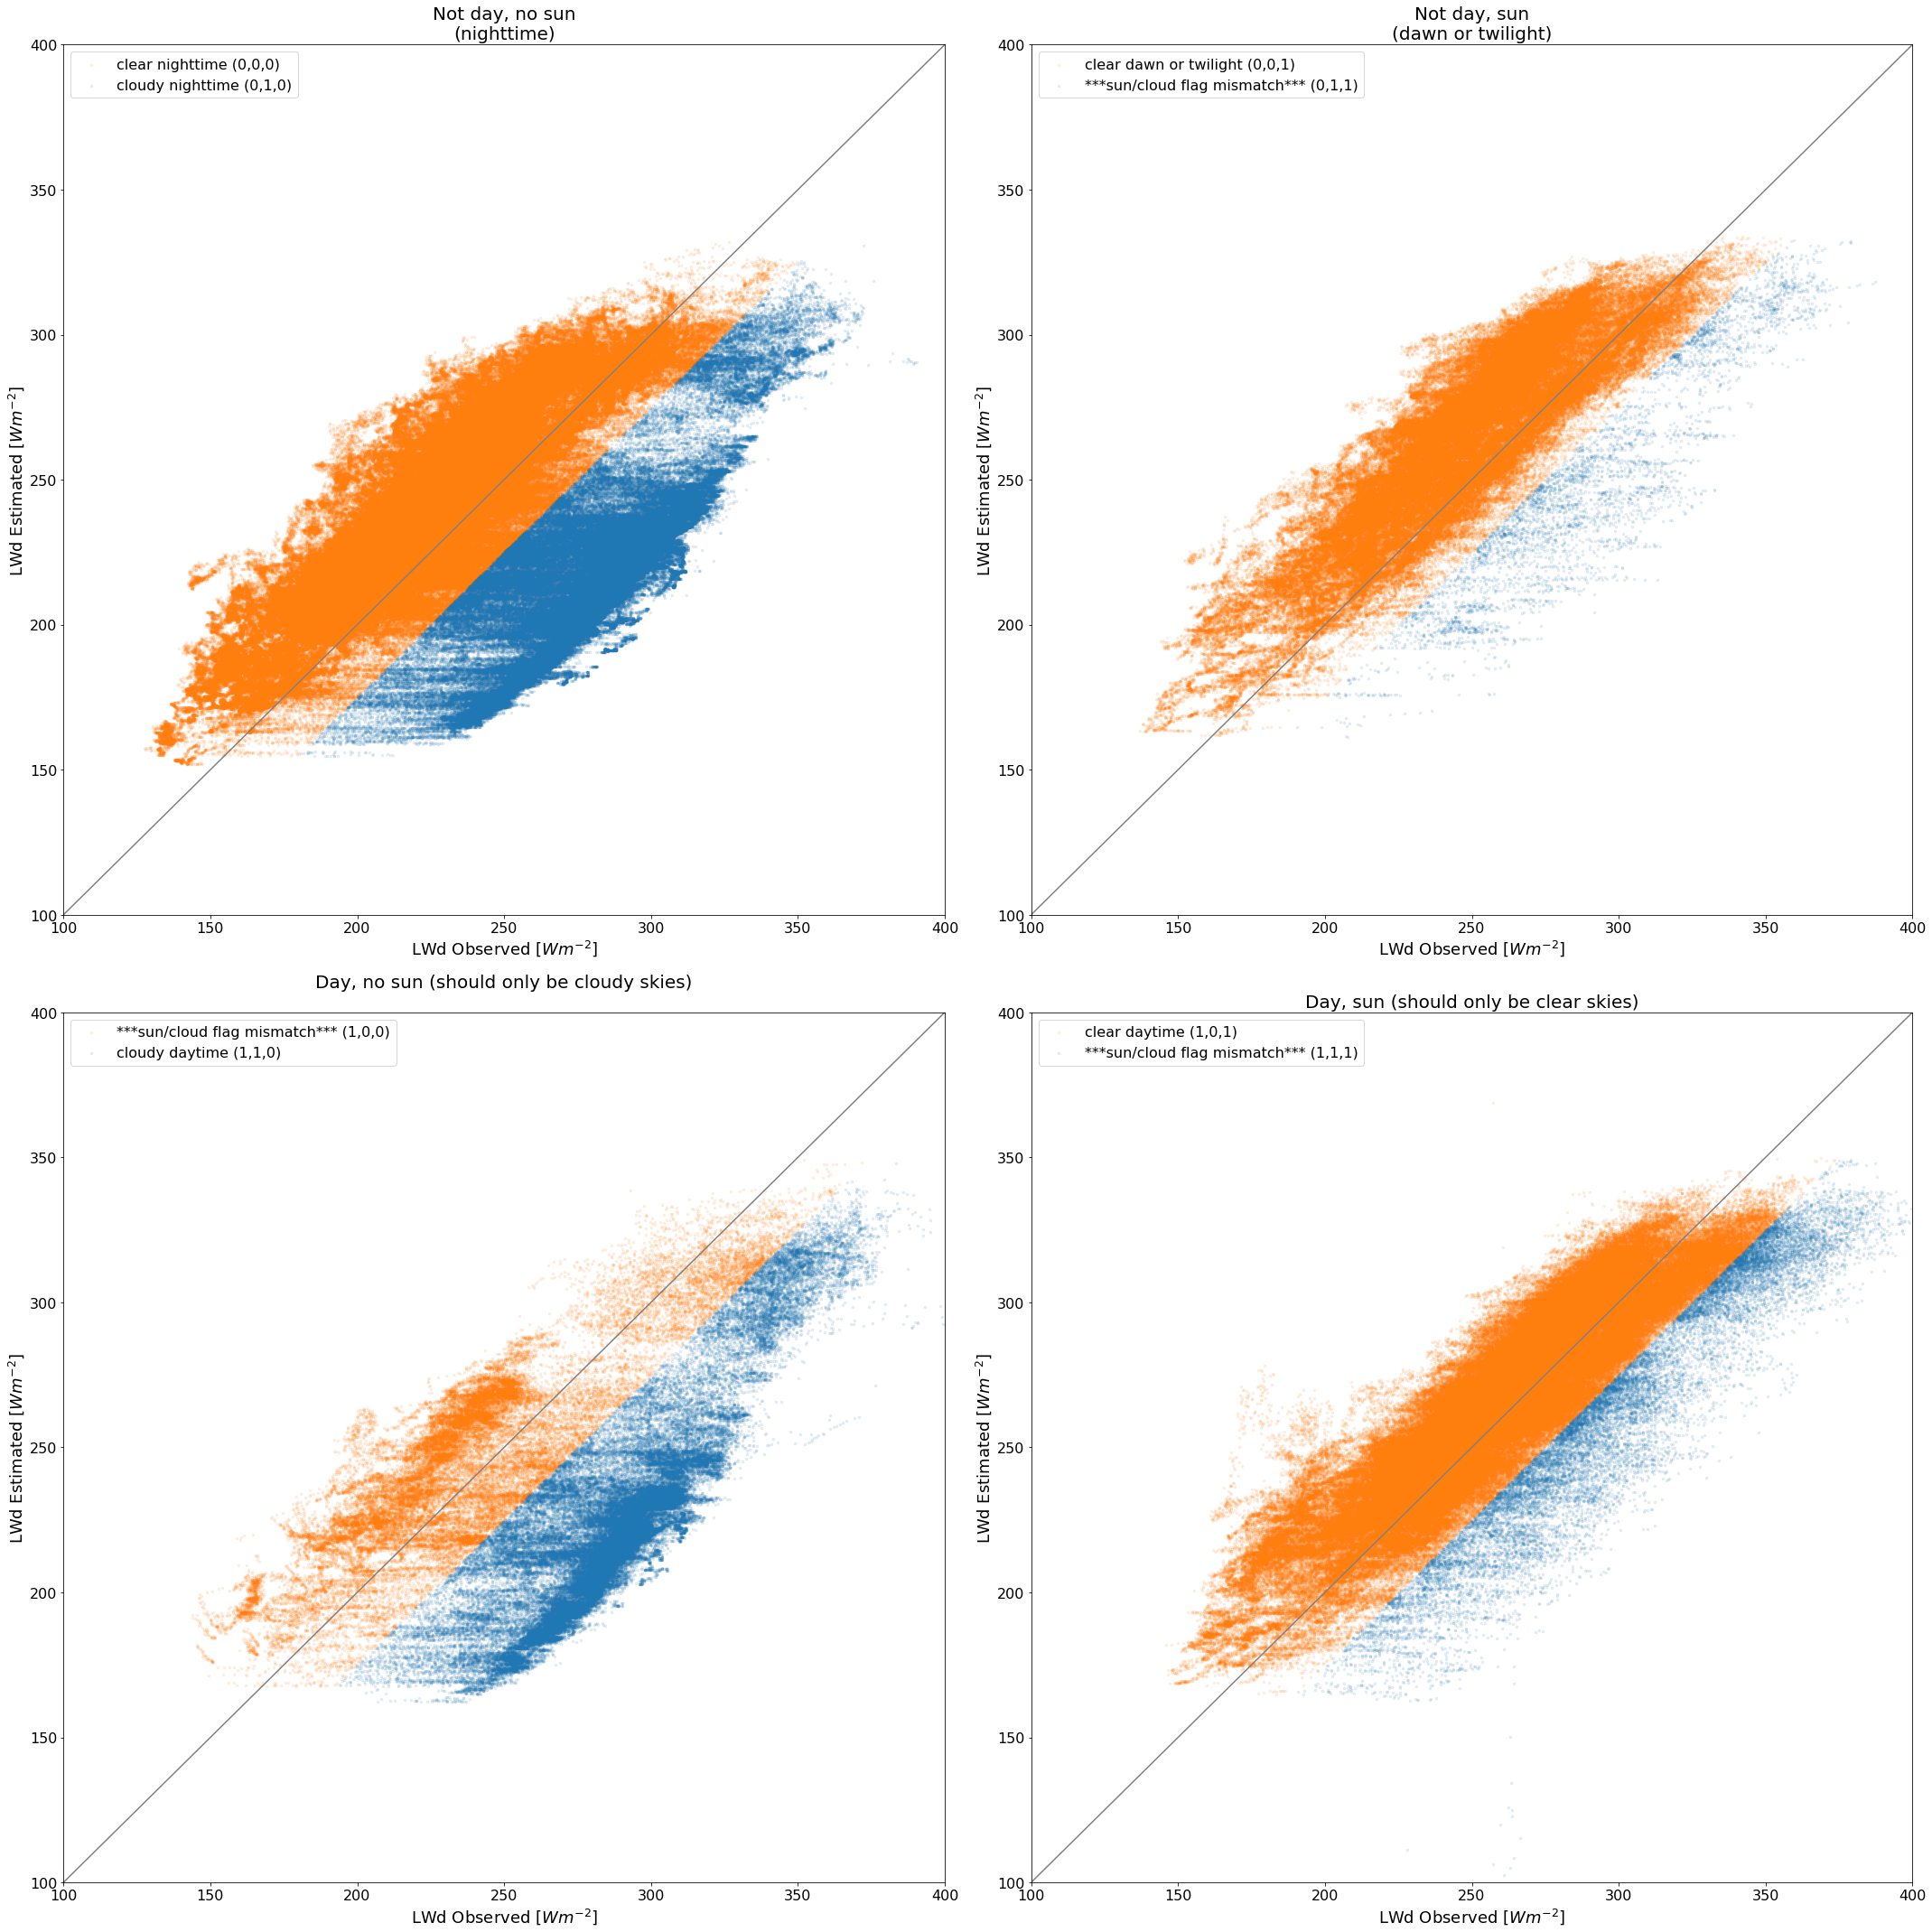

In [38]:
fig, ax = plt.subplots(2,2,figsize=(30,30))



### Not daytime, no sun
# Not day, no clouds, no sun (nighttime clear skies)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[0,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear nighttime (0,0,0)')
# Not day, clouds, no sun (nighttime cloudy skies)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[0,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='cloudy nighttime (0,1,0)')
ax[0,0].plot([0,400],[0,400],'-',c='grey')
ax[0,0].set_xlim([100,400])
ax[0,0].set_ylim([100,400])
ax[0,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,0].set_title('Not day, no sun\n(nighttime)')
ax[0,0].legend()



### Not daytime, sun
# Not day, no clouds, sun (we shouldn't see much here (early morning or late afternoon only))
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[0,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear dawn or twilight (0,0,1)')
# Not day, clouds, sun (we shouldnt see much here)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[0,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='***sun/cloud flag mismatch*** (0,1,1)')
ax[0,1].plot([0,400],[0,400],'-',c='grey')
ax[0,1].set_xlim([100,400])
ax[0,1].set_ylim([100,400])
ax[0,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,1].set_title('Not day, sun\n(dawn or twilight)')
ax[0,1].legend()




### Daytime, no sun
# Day, no clouds, no sun (we shouldnt see much here)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[1,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='***sun/cloud flag mismatch*** (1,0,0)')
# Day, clouds, no sun (daytime cloudy skies)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[1,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='cloudy daytime (1,1,0)')
ax[1,0].plot([0,400],[0,400],'-',c='grey')
ax[1,0].set_xlim([100,400])
ax[1,0].set_ylim([100,400])
ax[1,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,0].set_title('Day, no sun (should only be cloudy skies)\n')
ax[1,0].legend()



### Daytime, sun
# Day, no clouds, sun (clear skies)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[1,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear daytime (1,0,1)')
# Day, clouds, sun (we shouldnt see much here)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[1,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='***sun/cloud flag mismatch*** (1,1,1)')
ax[1,1].plot([0,400],[0,400],'-',c='grey')
ax[1,1].set_xlim([100,400])
ax[1,1].set_ylim([100,400])
ax[1,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,1].set_title('Day, sun (should only be clear skies)')
ax[1,1].legend()
                  

plt.tight_layout()

Plot some results zoomed in to a couple days:

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


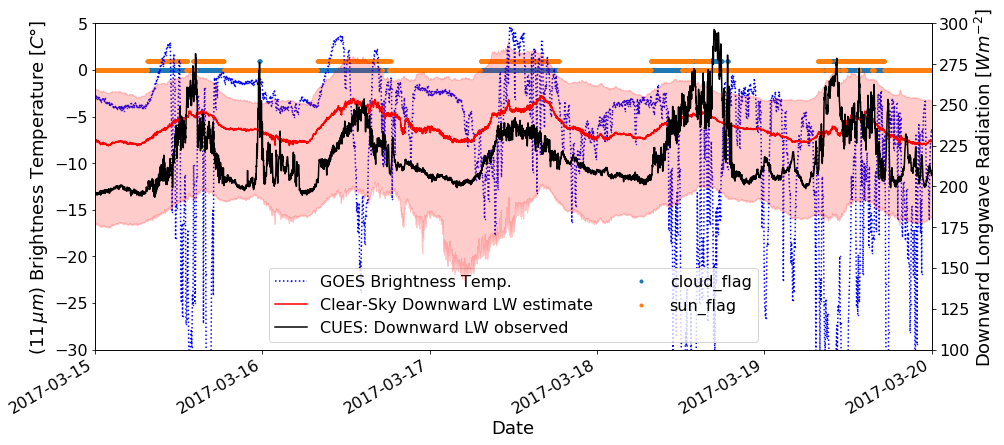

In [50]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,15)
enddate = pd.datetime(2017,3,20)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()


lw_ensemble.lclr_mean.plot(ax=ax2,alpha=1,c='r')
ax2.fill_between(lw_ensemble.datetime, lw_ensemble.lclr_max, lw_ensemble.lclr_min,color='r',alpha=0.2)


# Observed Downward Lognwave Radiation
cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2, c='k')

# sun/cloud/day flags
cues_ds.cloud_flag.plot(ax=ax,linestyle='none',marker='.')
#cues_ds.day_flag.plot(ax=ax,linestyle='none',marker='.')
cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'].plot(ax=ax,linestyle='none',marker='.')

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)
#
#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='b', linestyle=':', marker='.', markersize=1, ax=ax)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((100,300))
ax.set_ylim((-30,5))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]');

# make legend
lines = [ax.lines[2], ax2.lines[0], ax2.lines[1],
        ax.lines[0], ax.lines[1]]
labels = ['GOES Brightness Temp.', 'Clear-Sky Downward LW estimate', 'CUES: Downward LW observed',
         'cloud_flag', 'sun_flag']
ax.legend(lines, labels, loc='lower center', ncol=2)

---
---